# Goal
Predict the presence or absence of cardiac arrhythmia in a patient

## Process
1. Loading of dataset
1. Splitting of dataset to training and testing data (test_size = 20% of the whole dataset)
2. Building of a self-designed Logistic Regression model (Complete the TODO parts provided below)
3. Plotting of the confusion matrix. (Label 0 as positive)
4. Computing the F1-score of this confusion matrix. The F1-score should be at least 0.75

## Dataset
The [Arrhythmia](https://archive.ics.uci.edu/ml/datasets/Arrhythmia) dataset from UCI repository contains 280 variables collected from 452 patients. Its information helps in distinguishing between the presence and absence of cardiac arrhythmia and in classifying arrhytmia in one of the 16 groups. In this homework, we will just focus on building a Logistic Regression model that can classify between the presence and absence of arrhythmia.


Original class 1 refers to 'normal' ECG which we will regard as 'absence of arrhythmia' and the rest of the classes will be 'presence of arrhythmia'.

In [2]:
import pandas as pd
#load the data
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                   'arrhythmia/arrhythmia.data', header=None, sep=',', engine='python')

display(data.head(3))

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10


In [3]:
# see the size
print('%d rows and %d columns' % (data.shape[0], data.shape[1]))

452 rows and 280 columns


In [5]:
import numpy as np
# print the label
np.unique(data[len(data.columns)-1])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16], dtype=int64)

Let's make that column (class label) dichotomous.
Value is 0 if ECG is normal, 1 otherwise

In [6]:
data['arrhythmia'] = data[len(data.columns)-1].map(lambda x: 0 if x==1 else 1)
data = data.drop(len(data.columns)-2, axis=1)

In [7]:
data.groupby(['arrhythmia']).size()


arrhythmia
0    245
1    207
dtype: int64

Some columns have missing values denoted as '?'

To make the preprocessing simpler, let's just retain the columns with numeric values.

In [8]:
data = data._get_numeric_data()
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 275 columns


In [9]:
data.head(3)


,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,arrhythmia
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,1
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,1
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,1


In [10]:
X = data.iloc[:, :-1]  # The first to second-last columns are the features
y = data.iloc[:, -1]   # The last column is the ground-truth label
print(np.unique(y))
print(X.shape)

[0 1]
(452, 274)


In [13]:
from sklearn.model_selection import train_test_split

# splitting the dataset to training and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20181004)

In [15]:
from sklearn.preprocessing import StandardScaler

# Standardizing the training and test datasets
# Note that we are scaling based on the information from the training data
# Then we apply the scaling that is done from training data to the test data

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [112]:
class LogisticRegression(object):

    def __init__(self, eta=0.05, n_epoch=100, random_state=1):
        self.eta = eta
        self.n_epoch = n_epoch
        self.random_state = random_state
    
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_epoch):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            # add regularized term
            #self.w_[1:] += self.eta * X.T.dot(errors) + self.eta * 0.01 / len(y) * self.w_[1:]
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = self.loss(output, y)
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def loss(self, output, y):
        """Calculate loss"""
        epsilon = 1e-10    # prevent log (0) 
        m = len(y)
        J = 1 / m * sum(-y * np.log(output + epsilon) + (1-y) * np.log(1 - output + epsilon))
        #J += self.eta / (2 * m) * sum (self.w_ ** 2)
        return J
    
    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1 / (1 + np.exp(-z))

    def predict(self, X):
        """Return class label after unit step"""
        y_ = self.activation(self.net_input(X))
        mask = y_ < 1e-10
        y_[mask] = 0
        y_[~mask] = 1
        return y_

<ipython-input-112-3a09ab71631f>:39: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


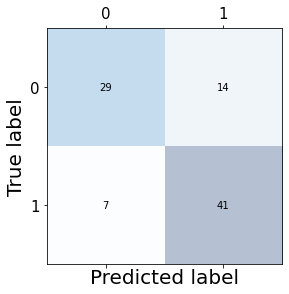

In [113]:
from sklearn.metrics import confusion_matrix, f1_score

# matplotlib  3.1.2
import matplotlib.pyplot as plt

lr = LogisticRegression(eta = 0.23600000000000018)
lr.fit(X_train_std, y_train)

y_pred = lr.predict(X_test_std)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('./output/fig-logistic-regression-confusion-2.png', dpi=300)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.show()

In [114]:
print('\n[F1-score]')
f = f1_score(y_true=y_test, y_pred=y_pred)
print(f)


[F1-score]
0.7961165048543689


In [115]:
# Explore the proper eta
for eta in np.arange(0.03, 0.3, 0.001):
    lr = LogisticRegression(eta = eta)
    lr.fit(X_train_std, y_train)

    y_pred = lr.predict(X_test_std)
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    f1 = f1_score(y_true=y_test, y_pred=y_pred)
    if f1 > 0.75:
        print('eta:', eta, 'f1-score:', f1)

eta: 0.08500000000000005 f1-score: 0.7592592592592592
eta: 0.09200000000000005 f1-score: 0.7592592592592592
eta: 0.10700000000000007 f1-score: 0.7547169811320755
eta: 0.12000000000000008 f1-score: 0.7619047619047619
eta: 0.12100000000000008 f1-score: 0.7547169811320755
eta: 0.1350000000000001 f1-score: 0.7547169811320755


<ipython-input-112-3a09ab71631f>:39: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


eta: 0.16800000000000012 f1-score: 0.7647058823529411
eta: 0.17700000000000013 f1-score: 0.7572815533980584
eta: 0.18000000000000013 f1-score: 0.7572815533980584
eta: 0.18100000000000013 f1-score: 0.7572815533980584
eta: 0.18300000000000013 f1-score: 0.7572815533980584
eta: 0.19500000000000015 f1-score: 0.7524752475247525
eta: 0.19600000000000015 f1-score: 0.7524752475247525
eta: 0.19900000000000015 f1-score: 0.7524752475247525
eta: 0.20600000000000016 f1-score: 0.7835051546391752
eta: 0.20900000000000016 f1-score: 0.7572815533980584
eta: 0.21600000000000016 f1-score: 0.7524752475247525
eta: 0.21800000000000017 f1-score: 0.7524752475247525
eta: 0.22200000000000017 f1-score: 0.76
eta: 0.22400000000000017 f1-score: 0.7572815533980584
eta: 0.22500000000000017 f1-score: 0.7524752475247525
eta: 0.23100000000000018 f1-score: 0.76
eta: 0.23600000000000018 f1-score: 0.7961165048543689
eta: 0.24000000000000019 f1-score: 0.7572815533980584
eta: 0.2450000000000002 f1-score: 0.7524752475247525
eta